In [80]:
import os
import numpy as np
import torch
import glob
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.optim import NAdam
from torch.autograd import Variable
import torchvision
import pathlib

In [50]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [51]:
print(device)

cuda


In [52]:
transformer=transforms.Compose([
    transforms.Resize((150,150)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),  #0-255 to 0-1, numpy to tensors
    transforms.Normalize([0.5,0.5,0.5], # 0-1 to [-1,1] , formula (x-mean)/std
                        [0.5,0.5,0.5])
])

In [53]:
train_path= r'C:\Users\DAWN\Documents\Python Scripts\python\data\train'
test_path= r'C:\Users\DAWN\Documents\Python Scripts\python\data\test'

train_loader=DataLoader(
    torchvision.datasets.ImageFolder(train_path,transform=transformer),
    batch_size=128, shuffle=True
)
test_loader=DataLoader(
    torchvision.datasets.ImageFolder(test_path,transform=transformer),
    batch_size=64, shuffle=True
)

In [54]:
root=pathlib.Path(train_path)
classes=sorted([j.name.split('/')[-1] for j in root.iterdir()])

In [55]:
print(classes)

['benign', 'malignant']


In [56]:
class ConvNet(nn.Module):
    def __init__(self,num_classes=2):
        super(ConvNet,self).__init__()
        
        #Output size after convolution filter
        #Input shape= (256,3,150,150)
        
        self.conv1=nn.Conv2d(in_channels=3,out_channels=12,kernel_size=5,stride=1,padding=2)
        #Shape= (256,12,150,150)
        self.bn1=nn.BatchNorm2d(num_features=12)
        #Shape= (256,12,150,150)
        self.relu1=nn.LeakyReLU()
        #Shape= (256,12,150,150)
        
        self.pool=nn.MaxPool2d(kernel_size=2)
        #Reduce the image size be factor 2
        #Shape= (256,12,75,75)
        
        self.conv2=nn.Conv2d(in_channels=12,out_channels=20,kernel_size=5,stride=1,padding=2)
        #Shape= (256,20,75,75)
        self.relu2=nn.LeakyReLU()
        #Shape= (256,20,75,75)
        
        self.conv3=nn.Conv2d(in_channels=20,out_channels=32,kernel_size=5,stride=1,padding=2)
        #Shape= (256,20,75,75)
        self.relu3=nn.LeakyReLU()
        #Shape= (256,20,75,75)
        
        self.conv4=nn.Conv2d(in_channels=32,out_channels=48,kernel_size=5,stride=1,padding=2)
        #Shape= (256,32,75,75)
        self.bn4=nn.BatchNorm2d(num_features=48)
        #Shape= (256,32,75,75)
        self.relu4=nn.LeakyReLU()
        #Shape= (256,32,75,75)
        
        self.fc=nn.Linear(in_features=75 * 75 * 48,out_features=num_classes)
        
    def forward(self,input):
        output=self.conv1(input)
        output=self.bn1(output)
        output=self.relu1(output)
            
        output=self.pool(output)
            
        output=self.conv2(output)
        output=self.relu2(output)

        output=self.conv3(output)
        output=self.relu3(output)
            
        output=self.conv4(output)
        output=self.bn4(output)
        output=self.relu4(output)
            
            #Above output will be in matrix form, with shape (256,32,75,75)
            
        output=output.view(-1,48*75*75)
        output=self.fc(output)            
        return output

In [92]:
model=ConvNet(num_classes=2).to(device)

In [58]:
optimizer=Adam(model.parameters(),lr=0.001,weight_decay=0.0001)
loss_function=nn.CrossEntropyLoss()

In [82]:
num_epochs=100

In [83]:
train_count=len(glob.glob(train_path+'/**/*.jpg'))
test_count=len(glob.glob(test_path+'/**/*.jpg'))

In [84]:
print(train_count,test_count)

2637 660


In [85]:
ta = [0]*100
tl = [0]*100
tea = [0]*100
tel = [0]*100

In [63]:
best_accuracy=0.0

for epoch in range(num_epochs):
    
    #Evaluation and training on training dataset
    model.train()
    train_accuracy=0.0
    train_loss=0.0
    
    for i, (images,labels) in enumerate(train_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        optimizer.zero_grad()
        
        outputs=model(images)
        loss=loss_function(outputs,labels)
        loss.backward()
        optimizer.step()
        
        train_loss+= loss.cpu().data*images.size(0)
        _,prediction=torch.max(outputs.data,1)
        train_accuracy+=int(torch.sum(prediction==labels.data))
        
    train_accuracy=train_accuracy/train_count
    train_loss=train_loss/train_count
    
    
    # Evaluation on testing dataset
    model.eval()
    test_accuracy=0.0
    test_loss=0.0
    for i, (images,labels) in enumerate(test_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        outputs=model(images)
        loss=loss_function(outputs,labels)
        loss.backward()
        optimizer.step()
        test_loss+= loss.cpu().data*images.size(0)
        _,prediction=torch.max(outputs.data,1)
        test_accuracy+=int(torch.sum(prediction==labels.data))
    
    test_accuracy=test_accuracy/test_count
    test_loss= test_loss/test_count
    
    print('Epoch: '+str(epoch)+' Train Loss: '+str(train_loss)+' Train Accuracy: '+str(train_accuracy)+' Test Accuracy: '+str(test_accuracy))
    ta[epoch] = train_accuracy
    tl[epoch] = train_loss
    tea[epoch] = test_accuracy
    tel[epoch] = test_loss
    
    #Save the best model
    if test_accuracy>best_accuracy:
        torch.save(model.state_dict(),'best_checkpoint_leakyrelu_48ch_4l.model')
        best_accuracy=test_accuracy

Epoch: 0 Train Loss: tensor(8.7377) Train Accuracy: 0.7186196435343193 Test Accuracy: 0.6924242424242424
Epoch: 1 Train Loss: tensor(38.0783) Train Accuracy: 0.6939704209328783 Test Accuracy: 0.5742424242424242
Epoch: 2 Train Loss: tensor(16.7027) Train Accuracy: 0.7042093287827076 Test Accuracy: 0.6363636363636364
Epoch: 3 Train Loss: tensor(79.5797) Train Accuracy: 0.6405005688282139 Test Accuracy: 0.6257575757575757
Epoch: 4 Train Loss: tensor(27.8581) Train Accuracy: 0.5794463405384908 Test Accuracy: 0.5515151515151515
Epoch: 5 Train Loss: tensor(367.3977) Train Accuracy: 0.46378460371634433 Test Accuracy: 0.5015151515151515
Epoch: 6 Train Loss: tensor(194.4618) Train Accuracy: 0.5915813424345847 Test Accuracy: 0.5863636363636363
Epoch: 7 Train Loss: tensor(90.4189) Train Accuracy: 0.45582100872203263 Test Accuracy: 0.49242424242424243
Epoch: 8 Train Loss: tensor(113.6964) Train Accuracy: 0.5472127417519909 Test Accuracy: 0.5969696969696969
Epoch: 9 Train Loss: tensor(92.7476) Trai

Epoch: 78 Train Loss: tensor(1.7578) Train Accuracy: 0.6442927569207433 Test Accuracy: 0.6530303030303031
Epoch: 79 Train Loss: tensor(1.2926) Train Accuracy: 0.5293894577171028 Test Accuracy: 0.5666666666666667
Epoch: 80 Train Loss: tensor(2.4310) Train Accuracy: 0.6173682214637846 Test Accuracy: 0.6333333333333333
Epoch: 81 Train Loss: tensor(1.1389) Train Accuracy: 0.608646188850967 Test Accuracy: 0.5742424242424242
Epoch: 82 Train Loss: tensor(2.0521) Train Accuracy: 0.6040955631399317 Test Accuracy: 0.6242424242424243
Epoch: 83 Train Loss: tensor(1.2928) Train Accuracy: 0.5601061812665908 Test Accuracy: 0.5757575757575758
Epoch: 84 Train Loss: tensor(2.1568) Train Accuracy: 0.6363291619264315 Test Accuracy: 0.6363636363636364
Epoch: 85 Train Loss: tensor(1.0513) Train Accuracy: 0.5665529010238908 Test Accuracy: 0.5803030303030303
Epoch: 86 Train Loss: tensor(2.2184) Train Accuracy: 0.6484641638225256 Test Accuracy: 0.6545454545454545
Epoch: 87 Train Loss: tensor(0.9714) Train Accu

In [64]:
import matplotlib.pyplot as plt

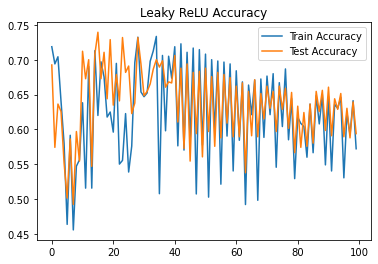

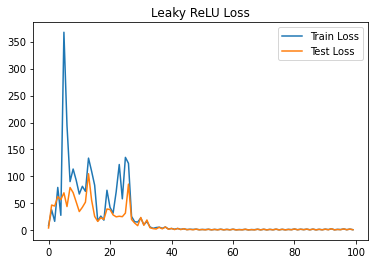

In [65]:
plt.title('Leaky ReLU Accuracy')
plt.plot(ta)
plt.plot(tea)
plt.legend(['Train Accuracy', 'Test Accuracy'])
plt.show()

plt.title('Leaky ReLU Loss')
plt.plot(tl)
plt.plot(tel)
plt.legend(['Train Loss', 'Test Loss'])
plt.show()

In [49]:
checkpoint = torch.load('best_checkpoint_leakyrelu.model')

In [50]:
model = ConvNet(num_classes=2)
model.load_state_dict(checkpoint)

<All keys matched successfully>

In [51]:
from prettytable import PrettyTable
def count_parameters(model):
    table = PrettyTable(['Modules', 'Parameters'])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

In [54]:
count_parameters(model)

+--------------+------------+
|   Modules    | Parameters |
+--------------+------------+
| conv1.weight |    324     |
|  conv1.bias  |     12     |
|  bn1.weight  |     12     |
|   bn1.bias   |     12     |
| conv2.weight |    2160    |
|  conv2.bias  |     20     |
| conv3.weight |    5760    |
|  conv3.bias  |     32     |
|  bn3.weight  |     32     |
|   bn3.bias   |     32     |
|  fc.weight   |   360000   |
|   fc.bias    |     2      |
+--------------+------------+
Total Trainable Params: 368398


368398

In [66]:
import torchinfo
torchinfo.summary(model, (3, 150, 150), batch_dim = 0, col_names = ('input_size', 'output_size', 'num_params', 'kernel_size', 'mult_adds'), verbose = 0)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Kernel Shape              Mult-Adds
ConvNet                                  [1, 3, 150, 150]          [1, 2]                    --                        --                        --
├─Conv2d: 1-1                            [1, 3, 150, 150]          [1, 12, 150, 150]         912                       [5, 5]                    20,520,000
├─BatchNorm2d: 1-2                       [1, 12, 150, 150]         [1, 12, 150, 150]         24                        --                        24
├─LeakyReLU: 1-3                         [1, 12, 150, 150]         [1, 12, 150, 150]         --                        --                        --
├─MaxPool2d: 1-4                         [1, 12, 150, 150]         [1, 12, 75, 75]           --                        2                         --
├─Conv2d: 1-5                            [1, 12, 75, 75]           [1, 20, 75, 75]           6,02

In [67]:
a = [0]*100
l = [0]*100
for i in range(0,100):
    a[i] = ta[i] - tea[i]
    l[i] = tel[i] - tl[i]
sa=0
sl=0
for i in range(0,100):
    sa = sa + a[i]
    sl = sl + l[i]

In [68]:
#Avg Difference in Accuracy
sa/100

-0.01503504326541869

In [69]:
#Avg Difference in Loss
sl/100

tensor(-11.1671)

In [70]:
sa1=0
sa2=0
sl1=0
sl2 = 0
for i in range(0,100):
    sa1 = sa1+ta[i]
    sl1 = sl1+tl[i]
    sa2 = sa2+tea[i]
    sl2 = sl2+tel[i]

In [75]:
sl2/100

tensor(14.2478)

In [76]:
#increasing depth

In [95]:
class ConvNet(nn.Module):
    def __init__(self,num_classes=2):
        super(ConvNet,self).__init__()
        
        #Output size after convolution filter
        #Input shape= (256,3,150,150)
        
        self.conv1=nn.Conv2d(in_channels=3,out_channels=12,kernel_size=3,stride=1,padding=1)
        #Shape= (256,12,150,150)
        self.bn1=nn.BatchNorm2d(num_features=12)
        #Shape= (256,12,150,150)
        self.relu1=nn.LeakyReLU()
        #Shape= (256,12,150,150)
        
        self.pool=nn.MaxPool2d(kernel_size=2)
        #Reduce the image size be factor 2
        #Shape= (256,12,75,75)
        
        self.conv2=nn.Conv2d(in_channels=12,out_channels=32,kernel_size=3,stride=1,padding=1)
        #Shape= (256,20,75,75)
        self.relu2=nn.LeakyReLU()
        #Shape= (256,20,75,75)
        
        self.conv5=nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1,padding=1)
        #Shape= (256,32,75,75)
        self.bn5=nn.BatchNorm2d(num_features=64)
        #Shape= (256,32,75,75)
        self.relu5=nn.LeakyReLU()
        #Shape= (256,32,75,75)
        
        self.fc=nn.Linear(in_features=75 * 75 * 64,out_features=num_classes)
        
    def forward(self,input):
        output=self.conv1(input)
        output=self.bn1(output)
        output=self.relu1(output)
            
        output=self.pool(output)
            
        output=self.conv2(output)
        output=self.relu2(output)

        output=self.conv3(output)
        output=self.relu3(output)
        
        output=self.conv4(output)
        output=self.relu4(output)
            
        output=self.conv5(output)
        output=self.bn5(output)
        output=self.relu5(output)
            
            #Above output will be in matrix form, with shape (256,32,75,75)
            
        output=output.view(-1,64*75*75)
        output=self.fc(output)            
        return output

In [96]:
optimizer=NAdam(model.parameters(),lr=0.0005,weight_decay=0.0001)
loss_function=nn.CrossEntropyLoss()

In [97]:
best_accuracy=0.0

for epoch in range(num_epochs):
    
    #Evaluation and training on training dataset
    model.train()
    train_accuracy=0.0
    train_loss=0.0
    
    for i, (images,labels) in enumerate(train_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        optimizer.zero_grad()
        
        outputs=model(images)
        loss=loss_function(outputs,labels)
        loss.backward()
        optimizer.step()
        
        train_loss+= loss.cpu().data*images.size(0)
        _,prediction=torch.max(outputs.data,1)
        train_accuracy+=int(torch.sum(prediction==labels.data))
        
    train_accuracy=train_accuracy/train_count
    train_loss=train_loss/train_count
    
    
    # Evaluation on testing dataset
    model.eval()
    test_accuracy=0.0
    test_loss=0.0
    for i, (images,labels) in enumerate(test_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        outputs=model(images)
        loss=loss_function(outputs,labels)
        loss.backward()
        optimizer.step()
        test_loss+= loss.cpu().data*images.size(0)
        _,prediction=torch.max(outputs.data,1)
        test_accuracy+=int(torch.sum(prediction==labels.data))
    
    test_accuracy=test_accuracy/test_count
    test_loss= test_loss/test_count
    
    print('Epoch: '+str(epoch)+' Train Loss: '+str(train_loss)+' Train Accuracy: '+str(train_accuracy)+' Test Accuracy: '+str(test_accuracy))
    ta[epoch] = train_accuracy
    tl[epoch] = train_loss
    tea[epoch] = test_accuracy
    tel[epoch] = test_loss
    
    #Save the best model
    if test_accuracy>best_accuracy:
        torch.save(model.state_dict(),'best_checkpoint_leakyrelu_64ch.model')
        best_accuracy=test_accuracy

RuntimeError: CUDA out of memory. Tried to allocate 132.00 MiB (GPU 0; 4.00 GiB total capacity; 3.12 GiB already allocated; 0 bytes free; 3.32 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF